In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_batch_size = 100
test_batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
temp = torch.tensor(np.random.randint(0, 10, (len(trainset),)))
trainset.targets = temp.tolist()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 4 * 4, 120)  
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)
        x = x.view(-1, 64 * 4 * 4)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
def train_single_epoch(model, train_loader, optimizer, criterion):
    total_train_loss = 0.0
    model.train()

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    return avg_train_loss

In [6]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_test_loss = 0.0
    total_correct = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            total_test_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(dim=1, keepdim=True)
            total_correct += preds.eq(labels.view_as(preds)).sum().item()

    avg_test_loss = total_test_loss / len(test_loader)
    accuracy = total_correct / len(test_loader.dataset)
    return avg_test_loss, accuracy

In [7]:
def log_epoch_results(epoch, avg_train_loss, avg_test_loss, accuracy):
    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.4f}')

In [8]:
def train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, epochs=100):
    train_losses  = []
    test_losses = []

    for epoch in range(epochs):
        avg_train_loss = train_single_epoch(model, train_loader, optimizer, criterion)
        train_losses.append(avg_train_loss)

        avg_test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(avg_test_loss)

        log_epoch_results(epoch, avg_train_loss, avg_test_loss, accuracy)

    return train_losses, test_losses


In [9]:
model = CNN_Model()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = train_and_evaluate_model(model, trainloader, testloader, optimizer, loss_func)

Epoch 1, Train Loss: 2.3157, Test Loss: 2.3049, Accuracy: 0.0784
Epoch 2, Train Loss: 2.3014, Test Loss: 2.3061, Accuracy: 0.0924
Epoch 3, Train Loss: 2.2968, Test Loss: 2.3272, Accuracy: 0.0826
Epoch 4, Train Loss: 2.2846, Test Loss: 2.3209, Accuracy: 0.0975
Epoch 5, Train Loss: 2.2544, Test Loss: 2.3466, Accuracy: 0.0889
Epoch 6, Train Loss: 2.1929, Test Loss: 2.4088, Accuracy: 0.0973
Epoch 7, Train Loss: 2.0922, Test Loss: 2.4624, Accuracy: 0.1071
Epoch 8, Train Loss: 1.9610, Test Loss: 2.6215, Accuracy: 0.0985
Epoch 9, Train Loss: 1.8187, Test Loss: 2.7621, Accuracy: 0.1050
Epoch 10, Train Loss: 1.6765, Test Loss: 2.9444, Accuracy: 0.1017
Epoch 11, Train Loss: 1.5406, Test Loss: 3.1792, Accuracy: 0.1023
Epoch 12, Train Loss: 1.4208, Test Loss: 3.4234, Accuracy: 0.1034
Epoch 13, Train Loss: 1.3081, Test Loss: 3.6756, Accuracy: 0.1054
Epoch 14, Train Loss: 1.2127, Test Loss: 3.9502, Accuracy: 0.1026
Epoch 15, Train Loss: 1.1212, Test Loss: 4.2436, Accuracy: 0.1020
Epoch 16, Train Los

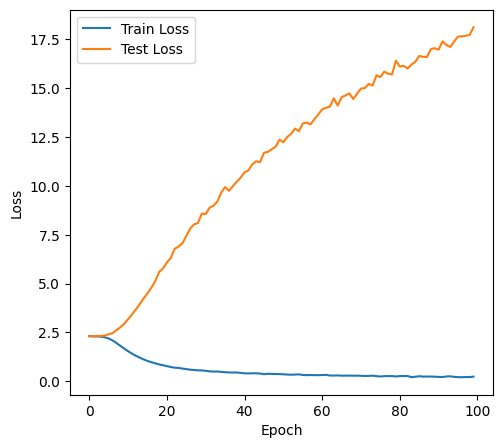

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()